In [ ]:
""" Prepare Notebook for Google Colab """
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
##### Google Colab #####
# Specify directory of course materials in Google Drive
module_dir = '/content/drive/My Drive/Colab Notebooks/COMP3359/Project/'

# Install necessary packages
!pip install pyspellchecker 

import sys
import pandas as pd
import string
import os
import numpy as np
import nltk

sys.path.append(module_dir)
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import casual_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
porter = PorterStemmer()
from spellchecker import SpellChecker
spell = SpellChecker(language=None, case_sensitive=True)
import matplotlib.pyplot as plt

     |████████████████████████████████| 2.7MB 7.6MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
##### Initialize Classes #####
class TwitterData_Initialize():
    data = []
    processed_data = []
    
    
    def initialize(self, csv_file):
        #load data into pandas
        self.data = pd.read_csv(csv_file,  names=['target', 'ids','datetime','flag','un','tweet'], encoding='latin-1')
        #remove unwanted columns
        self.data = self.data.drop(['ids','datetime','flag','un'], axis=1)

        self.processed_data = self.data
        

class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_numbers,
                               self.remove_special_chars,
                               self.remove_duplicate_characters,
                               self.correct_spelling,
                               self.remove_stopwords]:
            yield cleanup_method

    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "tweet"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "tweet"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        tweets["tweet"] = tweets["tweet"].apply(lambda x: regex.sub("\S*\d\S*", "", x).strip()) # to remove word entirely
        return tweets
      
    def remove_duplicate_characters(self, tweets):
        tweets["tweet"] = tweets["tweet"].apply(lambda x: regex.sub(r'([a-zA-Z])\1\1+', r'\1\1', x))
        return tweets

    def correct_spelling(self, tweets):
        tweets["tweet"] = tweets["tweet"].apply(lambda x: spell.correction(x).lower())
        return tweets

    def remove_stopwords(self, tweets):
        pattern = regex.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        tweets["tweet"] = tweets["tweet"].apply(lambda x: pattern.sub('', x))
        return tweets

class TwitterData_Cleansing(TwitterData_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            t = cleanup_method(t)
        self.processed_data = t

class TwitterData_TokenStem(TwitterData_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer = porter ):
        def stem_and_join(tweets):
            tweets["tweet"] = list(map(lambda str: stemmer.stem(str.lower()), tweets['tweet']))
            return tweets
        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer = casual_tokenize):
        t = self.processed_data
        t['tweet'] = t['tweet'].apply(tokenizer).tolist()
        # t['tokenized_tweet'] = t['tweet']
        self.processed_data = t

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

class TwitterData_Padding(TwitterData_TokenStem):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
 
    def padding(self, tokenizer = Tokenizer()):
        t = self.processed_data
        self.tokenizer = tokenizer
        t['token'] = t['tweet']
        pd.Series(t['token'])
        tokenizer.fit_on_texts(t['token'])
        t['token'] = tokenizer.texts_to_sequences(t['token'])  
        self.processed_data = t

In [ ]:
data_path = os.path.join(module_dir, "training.1600000.processed.noemoticon.csv")
data = TwitterData_Initialize()
data.initialize(data_path)
data.processed_data.head(5)

,target,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Replace the emoticons
import re as regex

positive_emoticons = [":)", ":-)", ":p", ":-p", ":P", ":-P", ";D", ";-D", ":D",":-D", ":]", ":-]", ";)", ";-)", ";p", ";-p", ";P", ";-P", ";D", ";-D", ";]", ";-]", "=)", "=-)", "<3"]
negative_emoticons = [":o", "D;", "D:", "D-:", ":-o", ":O", ":-O", ":(", ":-(", ":c", ":-c", ":C", ":-C", ":[", ":-[", ":/", ":-/", ":\\", ":-\\", ":n", ":-n", ":u", ":-u", "=(", "=-(", ":$", ":-$"]

def make_emoticon_pattern(emoticons):
    pattern = "|".join(map(regex.escape, emoticons))
    pattern = "(?<=\s)(" + pattern + ")(?=\s)"
    return pattern

def replace_emoticons(tweets, pattern, tag):
    tweets["tweet"]= tweets["tweet"].apply(lambda x: regex.sub(pattern, tag, " " + x + " "))
    return tweets

In [ ]:
data.processed_data = replace_emoticons(data.processed_data, make_emoticon_pattern(positive_emoticons), 'positive_emoticons')
data.processed_data = replace_emoticons(data.processed_data, make_emoticon_pattern(negative_emoticons), 'negative_emoticons')
data.processed_data.head(10)

,target,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww,..."
1,0,is upset that he can't update his Facebook b...
2,0,@Kenichan I dived many times for the ball. M...
3,0,my whole body feels itchy and like its on fi...
4,0,"@nationwideclass no, it's not behaving at al..."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [ ]:
data = TwitterData_Cleansing(data)
data.cleanup(TwitterCleanuper())
data.processed_data

,target,tweet
0,0,aww thats bummer shoulda got david carr thir...
1,0,upset cant update facebook texting might cry r...
2,0,dived many times ball managed save rest go b...
3,0,whole body feels itchy like fire
4,0,behaving im mad cant see
...,...,...
1599995,4,woke school best feeling ever
1599996,4,thewdbcom cool hear old walt interviews â«
1599997,4,ready mojo makeover ask details
1599998,4,happy birthday boo time tupac amaru shakur


In [ ]:
data = TwitterData_TokenStem(data)
data.tokenize()
data.stem()
data.processed_data

,target,tweet
0,0,"[aww, that, bummer, shoulda, got, david, carr,..."
1,0,"[upset, cant, updat, facebook, text, might, cr..."
2,0,"[dive, mani, time, ball, manag, save, rest, go..."
3,0,"[whole, bodi, feel, itchi, like, fire]"
4,0,"[behav, im, mad, cant, see]"
...,...,...
1599995,4,"[woke, school, best, feel, ever]"
1599996,4,"[thewdbcom, cool, hear, old, walt, interview, ..."
1599997,4,"[readi, mojo, makeov, ask, detail]"
1599998,4,"[happi, birthday, boo, time, tupac, amaru, sha..."


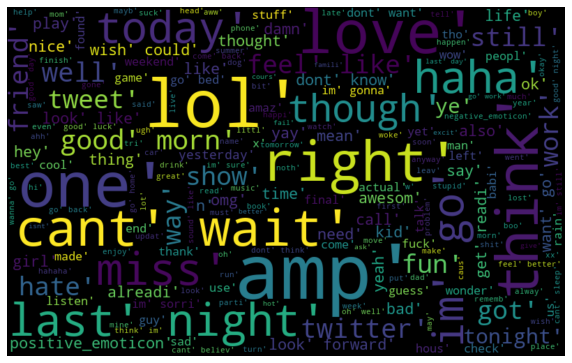

In [ ]:
# Show common words WORDCLOUD
import matplotlib.pyplot as plt
all_words = ''.join([str(text) for text in data.processed_data['tweet']]) 
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# Save 
data.processed_data.to_csv('/content/drive/My Drive/COMP3359 Project/preprocessed_data.csv', index = False)

In [ ]:
data = TwitterData_Padding(data)
data.padding()
data.processed_data

,target,tweet,token
0,0,"[aww, that, bummer, shoulda, got, david, carr,...","[109, 49, 1073, 3039, 13, 716, 6543, 1666, 4, ..."
1,0,"[upset, cant, updat, facebook, text, might, cr...","[601, 12, 225, 446, 368, 206, 240, 979, 80, 10..."
2,0,"[dive, mani, time, ball, manag, save, rest, go...","[3638, 226, 11, 877, 704, 506, 354, 2, 2798]"
3,0,"[whole, bodi, feel, itchi, like, fire]","[336, 662, 23, 2549, 7, 888]"
4,0,"[behav, im, mad, cant, see]","[4048, 1, 465, 12, 22]"
...,...,...,...
1599995,4,"[woke, school, best, feel, ever]","[254, 80, 106, 23, 154]"
1599996,4,"[thewdbcom, cool, hear, old, walt, interview, ...","[343026, 126, 177, 164, 10508, 767, 414, 431, ..."
1599997,4,"[readi, mojo, makeov, ask, detail]","[136, 6162, 6184, 296, 1529]"
1599998,4,"[happi, birthday, boo, time, tupac, amaru, sha...","[56, 186, 305, 11, 9686, 63410, 42782]"


Remove empty rows and find the length of each tweet.

In [ ]:
count = []
for i in range(len(data.processed_data['token'])):
  count.append(len(data.processed_data['token'][i]))
data.processed_data['count'] = count
data.processed_data = data.processed_data[(data.processed_data[['count']] != 0).all(axis=1)]
data.processed_data

,target,tweet,token,count
0,0,"[aww, that, bummer, shoulda, got, david, carr,...","[109, 49, 1073, 3039, 13, 716, 6543, 1666, 4, ...",10
1,0,"[upset, cant, updat, facebook, text, might, cr...","[601, 12, 225, 446, 368, 206, 240, 979, 80, 10...",12
2,0,"[dive, mani, time, ball, manag, save, rest, go...","[3638, 226, 11, 877, 704, 506, 354, 2, 2798]",9
3,0,"[whole, bodi, feel, itchi, like, fire]","[336, 662, 23, 2549, 7, 888]",6
4,0,"[behav, im, mad, cant, see]","[4048, 1, 465, 12, 22]",5
...,...,...,...,...
1599995,4,"[woke, school, best, feel, ever]","[254, 80, 106, 23, 154]",5
1599996,4,"[thewdbcom, cool, hear, old, walt, interview, ...","[343026, 126, 177, 164, 10508, 767, 414, 431, ...",9
1599997,4,"[readi, mojo, makeov, ask, detail]","[136, 6162, 6184, 296, 1529]",5
1599998,4,"[happi, birthday, boo, time, tupac, amaru, sha...","[56, 186, 305, 11, 9686, 63410, 42782]",7


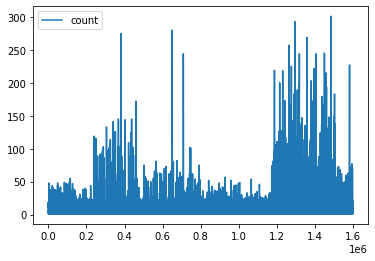

In [ ]:
lines = data.processed_data.plot.line(y = 'count')

In [ ]:
# Mean length
import math
mean_count = data.processed_data['count'].sum() / len(data.processed_data.index)
int_mean = math.ceil(mean_count)
print("Average number of words in a tweet:", int_mean)

Average number of words in a tweet: 8


In [ ]:
postpad_maxlen_posttrunc = pad_sequences(data.processed_data['token'], padding = 'post', maxlen = int_mean, truncating = 'post')
print(postpad_maxlen_posttrunc)

[[  109    49  1073 ...   716  6543  1666]
 [  601    12   225 ...   206   240   979]
 [ 3638   226    11 ...   506   354     2]
 ...
 [  136  6162  6184 ...     0     0     0]
 [   56   186   305 ... 63410 42782     0]
 [   56 13764     0 ...     0     0     0]]


In [ ]:
postpad_maxlen_posttrunc.shape

(1592682, 8)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2021-04-18 10:18:41--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2021-04-18 10:18:41--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-04-18 10:18:41--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [ ]:
!unzip glove.twitter.27B.zip -d '/content/drive/My Drive/COMP3359 Project/'

Archive:  glove.twitter.27B.zip
  inflating: /content/drive/My Drive/COMP3359 Project/glove.twitter.27B.25d.txt  
  inflating: /content/drive/My Drive/COMP3359 Project/glove.twitter.27B.50d.txt  
  inflating: /content/drive/My Drive/COMP3359 Project/glove.twitter.27B.100d.txt  
  inflating: /content/drive/My Drive/COMP3359 Project/glove.twitter.27B.200d.txt  


In [ ]:
import os
module_dir = '/content/drive/My Drive/COMP3359 Project'
os.chdir(module_dir)
!ls

glove.840B.300d.txt  glove.twitter.27B.100d.txt  model.h5  my_model.h5


In [ ]:
glove_file = "/content/drive/My Drive/COMP3359 Project/glove.twitter.27B.100d.txt"

import tqdm

EMBEDDING_VECTOR_LENGTH = 100 # <=200
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file,'r', encoding='utf8') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix

embedding_matrix =  construct_embedding_matrix(glove_file, data.tokenizer.word_index)

100%|██████████| 343026/343026 [00:00<00:00, 742294.14it/s]


In [ ]:
from sklearn.model_selection import train_test_split

x = postpad_maxlen_posttrunc
y = np.reshape(data.processed_data['target'].values, (data.processed_data['target'].shape[0], 1))
y[y == 4] = 1


x_train, x_test, y_train, y_test = train_test_split(x, y)
print(y_train.shape)
print(x_train.shape)

(1194511, 1)
(1194511, 8)


In [ ]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(x_train, y_train)

In [ ]:
x_train[:5]

array([[ 14786,    316,     11,    116,    445,    389,    228,    249],
       [   829,   6585,   2836,   1084,      0,      0,      0,      0],
       [   347,     10,    366,    648,   2427,    613,    314,     21],
       [    87,      5,   9833,    847,   1171,      4,  23119,     55],
       [  3903, 265519,  66630,    151,     93,      9,   4065,  66630]],
      dtype=int32)

In [ ]:
y_train[:5]

array([[0],
       [1],
       [1],
       [0],
       [1]])

In [ ]:
embedding_matrix.shape

(343027, 100)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential
import numpy as np

In [ ]:
VOCAB_SIZE = embedding_matrix.shape[0]
EMBEDDING_DIM = 100

model = Sequential(
    [
      Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights = [embedding_matrix], trainable = False),
      Bidirectional(LSTM(EMBEDDING_DIM, dropout=0.1, return_sequences=True)),
      Bidirectional(LSTM(EMBEDDING_DIM)),
      Dense(24, activation='relu'), 
      Dense(24, activation='relu'),
      Dense(1, activation='sigmoid')
    ]
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         34302700  
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_6 (Dense)              (None, 24)                4824      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 25        
Total params: 34,709,749
Trainable params: 407,049
Non-trainable params: 34,302,700
____________________________________

In [ ]:
xval = x_train[:20000]
yval = y_train[:20000]

x_train = x_train[20000:]
y_train = y_train[20000:]

**30 epoch**

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
h = model.fit(x_train, y_train, epochs = 30, batch_size= 50000, validation_data=(xval, yval), shuffle=True, verbose=1)

Epoch 1/30
24/24 [==============================] - 39s 1s/step - loss: 0.3627 - accuracy: 0.8356 - val_loss: 0.5717 - val_accuracy: 0.7472
Epoch 2/30
24/24 [==============================] - 31s 1s/step - loss: 0.3186 - accuracy: 0.8575 - val_loss: 0.5999 - val_accuracy: 0.7480
Epoch 3/30
24/24 [==============================] - 31s 1s/step - loss: 0.3120 - accuracy: 0.8604 - val_loss: 0.5937 - val_accuracy: 0.7487
Epoch 4/30
24/24 [==============================] - 31s 1s/step - loss: 0.3132 - accuracy: 0.8598 - val_loss: 0.5973 - val_accuracy: 0.7482
Epoch 5/30
24/24 [==============================] - 31s 1s/step - loss: 0.3118 - accuracy: 0.8605 - val_loss: 0.5996 - val_accuracy: 0.7473
Epoch 6/30
24/24 [==============================] - 31s 1s/step - loss: 0.3114 - accuracy: 0.8612 - val_loss: 0.5941 - val_accuracy: 0.7491
Epoch 7/30
24/24 [==============================] - 31s 1s/step - loss: 0.3122 - accuracy: 0.8605 - val_loss: 0.6007 - val_accuracy: 0.7492
Epoch 8/30
24/24 [==

<Figure size 720x360 with 0 Axes>

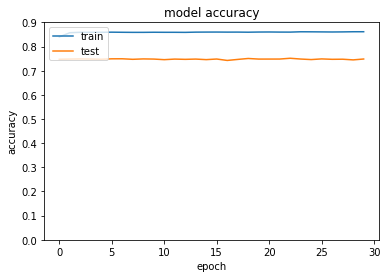

<Figure size 720x360 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yticks(np.arange(0, 1, 0.1))
plt.figure(figsize=(10,5))


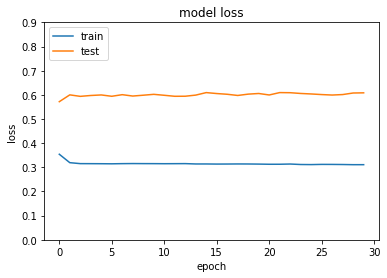

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

In [ ]:
scores = model.evaluate(x_test, y_test)

12443/12443 [==============================] - 86s 7ms/step - loss: 0.5846 - accuracy: 0.7479


In [ ]:
print(scores)

[0.5845739245414734, 0.7478947639465332]


In [ ]:
model.save("model.h5")